# CITE-seq analysis in R


In this brief tutorial, we go over how to use scvi-tools functionality in R for analyzing CITE-seq data. We will closely follow the Bioconductor PBMC [tutorial](https://bioconductor.org/books/release/OSCA/human-pbmc-with-surface-proteins-10x-genomics.html), using totalVI when appropriate.

This tutorial requires Reticulate. Please check out our installation [guide](https://www.scvi-tools.org/en/latest/installation.html#scvi-tools-installation-for-R) for instructions on installing Reticulate and scvi-tools.

## Loading and processing data with Bioconductor

In [3]:
library(BiocFileCache)
bfc <- BiocFileCache(ask=FALSE)
exprs.data <- bfcrpath(bfc, file.path(
    "http://cf.10xgenomics.com/samples/cell-vdj/3.1.0",
    "vdj_v1_hs_pbmc3",
    "vdj_v1_hs_pbmc3_filtered_feature_bc_matrix.tar.gz"))
untar(exprs.data, exdir=tempdir())

library(DropletUtils)
sce.pbmc <- read10xCounts(file.path(tempdir(), "filtered_feature_bc_matrix"))
sce.pbmc <- splitAltExps(sce.pbmc, rowData(sce.pbmc)$Type)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

## Pre-processing and quality control


In [4]:
unfiltered <- sce.pbmc

In [5]:
library(scater)
is.mito <- grep("^MT-", rowData(sce.pbmc)$Symbol)
stats <- perCellQCMetrics(sce.pbmc, subsets=list(Mito=is.mito))

high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
low.adt <- stats$`altexps_Antibody Capture_detected` < nrow(altExp(sce.pbmc))/2

discard <- high.mito | low.adt
sce.pbmc <- sce.pbmc[,!discard]

Loading required package: scuttle

Loading required package: ggplot2



In [6]:
summary(high.mito)

   Mode   FALSE    TRUE 
logical    6660     571 

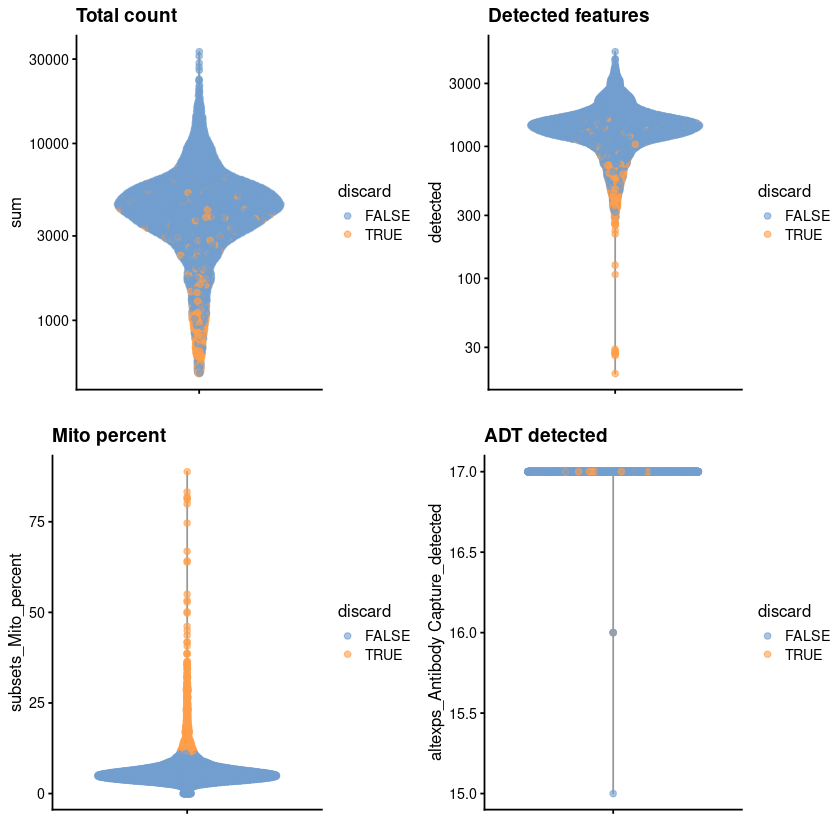

In [7]:
colData(unfiltered) <- cbind(colData(unfiltered), stats)
unfiltered$discard <- discard

gridExtra::grid.arrange(
    plotColData(unfiltered, y="sum", colour_by="discard") +
        scale_y_log10() + ggtitle("Total count"),
    plotColData(unfiltered, y="detected", colour_by="discard") +
        scale_y_log10() + ggtitle("Detected features"),
    plotColData(unfiltered, y="subsets_Mito_percent",
        colour_by="discard") + ggtitle("Mito percent"),
    plotColData(unfiltered, y="altexps_Antibody Capture_detected",
        colour_by="discard") + ggtitle("ADT detected"),
    ncol=2
)

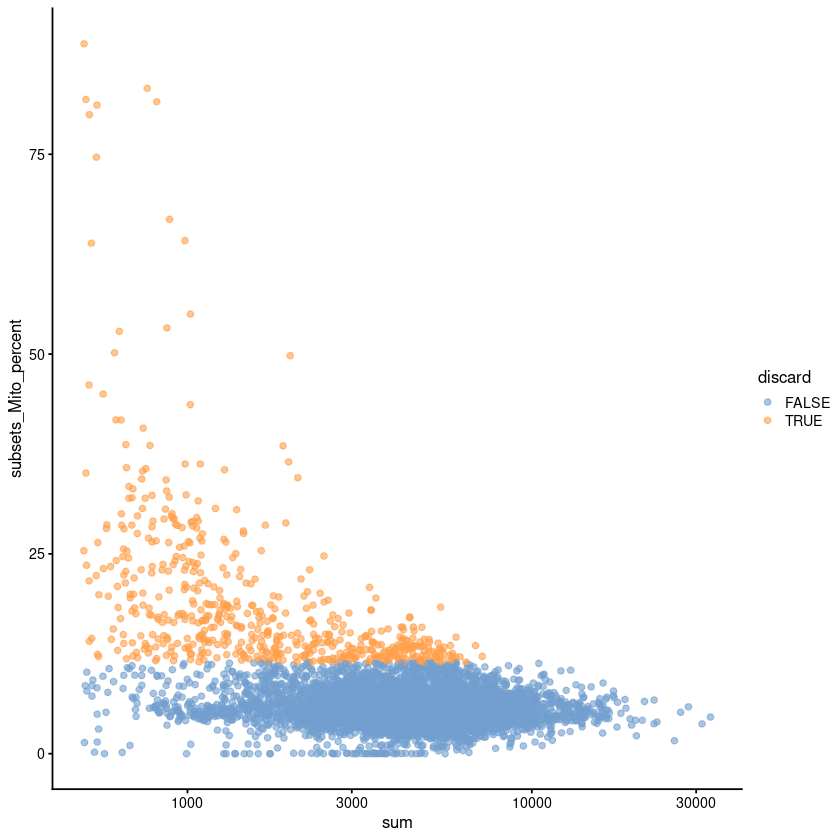

In [8]:
plotColData(unfiltered, x="sum", y="subsets_Mito_percent",
    colour_by="discard") + scale_x_log10()

## Normalization

While we normalize the data here using standard Bioconductor practices, we will use the counts later for totalVI.

In [11]:
library(scran)

set.seed(1000)
clusters <- quickCluster(sce.pbmc)
sce.pbmc <- computeSumFactors(sce.pbmc, cluster=clusters)
altExp(sce.pbmc) <- computeMedianFactors(altExp(sce.pbmc))
sce.pbmc <- logNormCounts(sce.pbmc, use_altexps=TRUE)

Warning message:
“'use.altexps=' is deprecated.
Use 'applySCE(x, logNormCounts)' instead.”


## Data conversion (SCE -> AnnData)

We use sceasy for conversion, and load the necessary Python packages for later.

In [30]:
library(reticulate)
library(sceasy)
library(anndata)
use_python("/home/adam/.pyenv/versions/3.9.7/bin/python", required = TRUE)
sc <- import("scanpy", convert = FALSE)
scvi <- import("scvi", convert = FALSE)
sys <- import ("sys", convert = FALSE)

We make two AnnData objects, one per modality, and then store the protein counts in the canonical location for scvi-tools.

In [24]:
adata <- convertFormat(sce.pbmc, from="sce", to="anndata", main_layer="counts", drop_single_values=FALSE)
adata_protein <- convertFormat(altExp(sce.pbmc), from="sce", to="anndata", main_layer="counts", drop_single_values=FALSE)
adata$obsm["protein"] <- adata_protein$to_df()

In [28]:
adata

AnnData object with n_obs × n_vars = 6660 × 33538
    obs: 'Sample', 'Barcode', 'sizeFactor'
    var: 'ID', 'Symbol', 'Type'
    obsm: 'protein'

## Run totalVI for dimensionality reduction

totalVI will output a low-dimensional representation of cells that captures information from both the RNA and protein. Here we show how to use totalVI for only dimensionality reduction, though totalVI can perform other tasks that are shown in the Python-based tutorials. The intention here is to provide some examples of how to use totalVI from R.

In [31]:
scvi$data$setup_anndata(adata, protein_expression_obsm_key="protein")

None

None

In [32]:
vae <- scvi$model$TOTALVI(adata)
vae$train()

None

In [38]:
reducedDims(sce.pbmc) <- list(TOTALVI=py_to_r(vae$get_latent_representation()))
sce.pbmc <- runUMAP(sce.pbmc, dimred="TOTALVI")
sce.pbmc <- runTSNE(sce.pbmc, dimred="TOTALVI")

## Clustering

In [39]:
g <- buildSNNGraph(sce.pbmc, k=10, use.dimred = 'TOTALVI')
clust <- igraph::cluster_walktrap(g)$membership
colLabels(sce.pbmc) <- factor(clust)

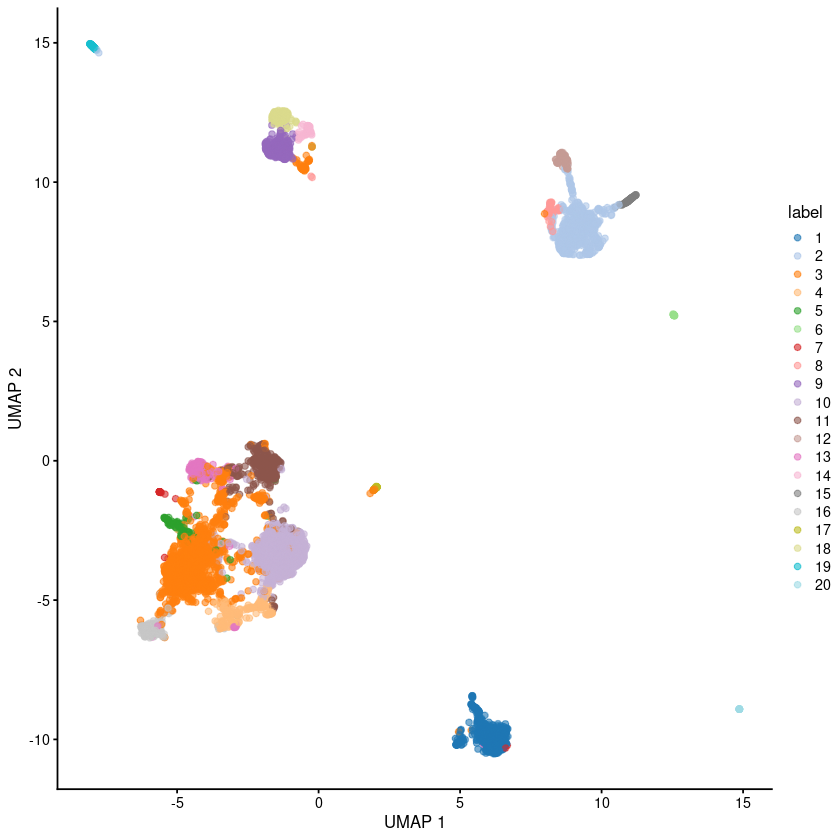

In [37]:
plotUMAP(sce.pbmc, colour_by="label")

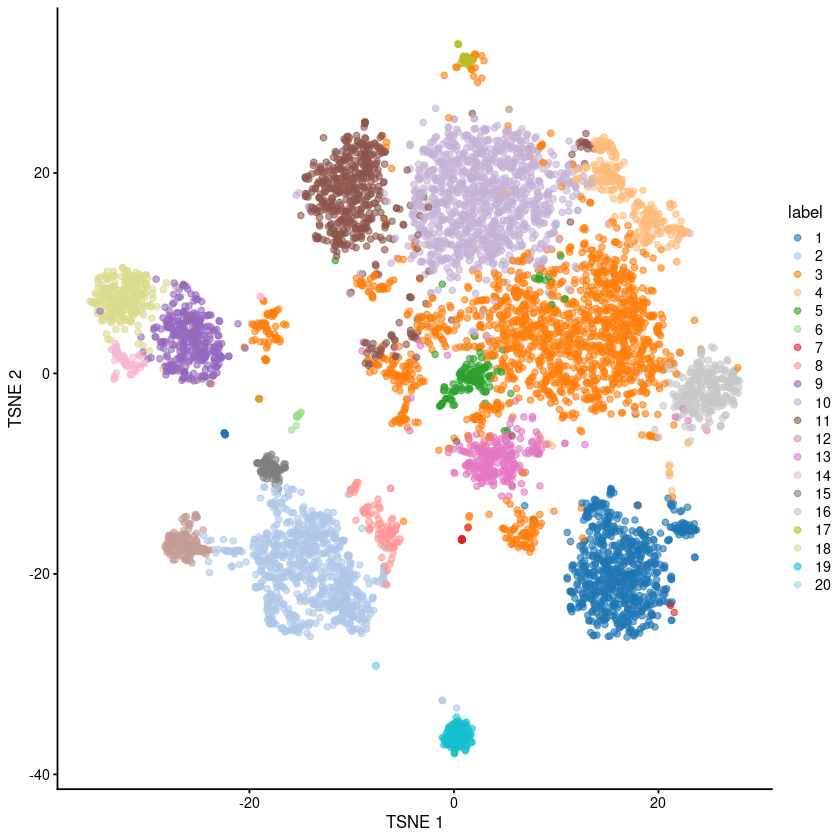

In [40]:
plotTSNE(sce.pbmc, colour_by="label")

In [43]:
sI <- sessionInfo()
sI$loadedOnly <- NULL
print(sI, locale=FALSE)

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] anndata_0.7.5.3             sceasy_0.0.6               
 [3] reticulate_1.20             scran_1.21.3               
 [5] scater_1.21.3               ggplot2_3.3.5              
 [7] scuttle_1.3.1               DropletUtils_1.13.2        
 [9] SingleCellExperiment_1.15.2 SummarizedExperiment_1.23.4
[11] Biobase_2.53.0              GenomicRanges_1.45.0       
[13] GenomeInfoDb_1.29.8         IRanges_2.27.2             
[15] S4Vectors_0.31.3            BiocGenerics_0.39.2        
[17] MatrixGenerics_1.5.4        matrixStats_0.60.1         
[19] BiocFileCache_2.1.1         dbplyr_2.1.1               
